# Predizione degli overall dei calciatori delle varie versioni di FIFA nei 3 anni successivi

# Import delle librerie e del dataset

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import numpy as np

# Caricare il dataset con low_memory=False per evitare l'avviso
df = pd.read_csv("male_players.csv", low_memory=False)

# Preprocessing dei dati

Rimozione dei portieri in quanto presentavano caratteristiche diverse rispetto agli altri giocatori

In [ ]:
# Rimozione dei portieri
portieri = df.loc[df['player_positions'] == 'GK']
df = df.drop(portieri.index)

Codifiche one-hot per gli attributi che ne necessitano

In [ ]:
# Gestione delle etichette dei giocatori (player_tags)
#Split dei tag in liste
df['player_tags'] = df['player_tags'].str.split(', ')
#Applicazione della codifica one-hot
tags = df['player_tags'].explode().str.strip().str.replace('#', '')
df = pd.concat([df, pd.crosstab(tags.index, tags).add_prefix('tag_')], axis=1)
#Eliminazione della colonna originale dei tags
df = df.drop(columns=['player_tags'])

# Gestione delle caratteristiche dei giocatori (player_traits)
#Split delle traits in liste
df['player_traits'] = df['player_traits'].str.split(', ')
#Apllicazione della codifica one-hot
traits = df['player_traits'].explode().str.strip().str.replace('+', '').str.replace(' ', '_').str.lower()
df = pd.concat([df, pd.crosstab(traits.index, traits).add_prefix('trait_')], axis=1)
#Eliminazione della colonna originale dei traits
df = df.drop(columns=['player_traits'])

Eliminazione delle versioni dei giocatori per cui non è possibile raccogliere gli overall nei successivi tre anni e creazione delle colonne relative agli overall di 3 anni successivi

In [ ]:
# Ordinamento dei dati per "player_id" e "fifa_version"
df = df.sort_values(['player_id', 'fifa_version'])

# Calcolo dell'overall nei prossimi tre anni
df['overall_next_year'] = df.groupby('player_id')['overall'].shift(-1)
df['overall_next_2year'] = df.groupby('player_id')['overall'].shift(-2)
df['overall_next_3year'] = df.groupby('player_id')['overall'].shift(-3)

#Eliminazione delle righe per le quali non è possibile raccogliere i dati
df = df.dropna(subset=['overall_next_year', 'overall_next_2year', 'overall_next_3year'])

Pulizia del dataset

In [ ]:
# Rimozione delle colonne con tutti i valori nulli o non significative
df = df.dropna(axis=1, how='all')
df = df.drop(['club_loaned_from', 'nation_team_id', 'nation_position', 'nation_jersey_number', 'player_url', 'short_name', 'long_name', 'dob', 'real_face', 'fifa_update', 'update_as_of', 'club_joined_date', 'club_position', 'potential'], axis=1)

Codifica delle colonne categoriche

In [ ]:
# Codifica delle caratteristiche categoriche
categorical_cols = ['player_positions', 'preferred_foot', 'club_name', 'league_name', 'nationality_name', 'work_rate', 'body_type']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le #Salvataggio dell'encoder per eventuali usi futuri (inversa della trasformazione)

# Pulizia delle colonne oggetto
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.split('+').str[0]
        df[col] = df[col].str.split('-').str[0]

Normalizzazione delle caratteristiche numeriche

In [ ]:
# Imputazione dei valori mancanti per le colonne numeriche
numerical_cols = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='mean')
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

# Standardizzazione delle colonne numeriche
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

Feature Engineering

In [ ]:
# Aggiunta di ulteriori caratteristiche di supporto

# Calcolo delle nuove caratteristiche
overall_trend = df.groupby('player_id')['overall'].transform(lambda x: x.diff().mean())
average_rating = df[['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']].mean(axis=1)
new_features = pd.DataFrame({'overall_trend': overall_trend, 'average_rating': average_rating})

# Unire il dataframe originale con le nuove caratteristiche
df = pd.concat([df.reset_index(drop=True), new_features], axis=1)

# Imputazione dei valori mancanti per le nuove caratteristiche
df[['overall_trend', 'average_rating']] = imputer.fit_transform(df[['overall_trend', 'average_rating']])

# Controllo e rimozione di eventuali NaN residui
df = df.dropna()

# PCA per ridurre la dimensionalità mantenendo il 95% della varianza
pca = PCA(n_components=0.95)
df_pca = pca.fit_transform(df[numerical_cols])
df_pca = pd.DataFrame(df_pca, columns=[f'pca_{i+1}' for i in range(df_pca.shape[1])])

# Unire il dataframe originale con le componenti principali
df = pd.concat([df.reset_index(drop=True), df_pca], axis=1)

# Salvataggio del dataset preprocessato
df.to_csv('new_file.csv', index=False)

# Ricarica del Dataset Preprocessato e Suddivisione nei Set di Addestramento, Validazione e Test

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Caricare il dataset preprocessato
df = pd.read_csv("new_file.csv")

# Divisione del dataset in set di addestramento 80%, validazione 10% e test 10%
X = df.drop(['overall_next_year', 'overall_next_2year', 'overall_next_3year'], axis=1)
y1 = df['overall_next_year']
y2 = df['overall_next_2year']
y3 = df['overall_next_3year']

X_train, X_temp, y1_train, y1_temp = train_test_split(X, y1, test_size=0.2, random_state=42)
_, _, y2_train, y2_temp = train_test_split(X, y2, test_size=0.2, random_state=42)
_, _, y3_train, y3_temp = train_test_split(X, y3, test_size=0.2, random_state=42)

X_val, X_test, y1_val, y1_test = train_test_split(X_temp, y1_temp, test_size=0.5, random_state=42)
_, _, y2_val, y2_test = train_test_split(X_temp, y2_temp, test_size=0.5, random_state=42)
_, _, y3_val, y3_test = train_test_split(X_temp, y3_temp, test_size=0.5, random_state=42)


# Script 1: Addestramento RandomForestRegressor

In [48]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import joblib

# Caricamento del dataset preprocessato
df = pd.read_csv("new_file.csv")

# Divisione del dataset in set di addestramento, validazione e test
X = df.drop(['overall_next_year', 'overall_next_2year', 'overall_next_3year'], axis=1)
y1 = df['overall_next_year']
y2 = df['overall_next_2year']
y3 = df['overall_next_3year']

X_train, X_temp, y1_train, y1_temp = train_test_split(X, y1, test_size=0.2, random_state=42)
_, _, y2_train, y2_temp = train_test_split(X, y2, test_size=0.2, random_state=42)
_, _, y3_train, y3_temp = train_test_split(X, y3, test_size=0.2, random_state=42)

X_val, X_test, y1_val, y1_test = train_test_split(X_temp, y1_temp, test_size=0.5, random_state=42)
_, _, y2_val, y2_test = train_test_split(X_temp, y2_temp, test_size=0.5, random_state=42)
_, _, y3_val, y3_test = train_test_split(X_temp, y3_temp, test_size=0.5, random_state=42)

# Addestramento dei modelli RandomForestRegressor
rf1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf1.fit(X_train, y1_train)
rf2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf2.fit(X_train, y2_train)
rf3 = RandomForestRegressor(n_estimators=100, random_state=42)
rf3.fit(X_train, y3_train)

# Salvataggio dei modelli addestrati
joblib.dump(rf1, 'rf1_model.pkl')
joblib.dump(rf2, 'rf2_model.pkl')
joblib.dump(rf3, 'rf3_model.pkl')


['rf3_model.pkl']

# Script 2: Addestramento GradientBoostingRegressor

In [49]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import joblib

# Caricamento del dataset preprocessato
df = pd.read_csv("new_file.csv")

# Divisione del dataset in set di addestramento, validazione e test
X = df.drop(['overall_next_year', 'overall_next_2year', 'overall_next_3year'], axis=1)
y1 = df['overall_next_year']
y2 = df['overall_next_2year']
y3 = df['overall_next_3year']

X_train, X_temp, y1_train, y1_temp = train_test_split(X, y1, test_size=0.2, random_state=42)
_, _, y2_train, y2_temp = train_test_split(X, y2, test_size=0.2, random_state=42)
_, _, y3_train, y3_temp = train_test_split(X, y3, test_size=0.2, random_state=42)

X_val, X_test, y1_val, y1_test = train_test_split(X_temp, y1_temp, test_size=0.5, random_state=42)
_, _, y2_val, y2_test = train_test_split(X_temp, y2_temp, test_size=0.5, random_state=42)
_, _, y3_val, y3_test = train_test_split(X_temp, y3_temp, test_size=0.5, random_state=42)

# Addestramento dei modelli GradientBoostingRegressor
gb1 = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb1.fit(X_train, y1_train)
gb2 = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb2.fit(X_train, y2_train)
gb3 = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb3.fit(X_train, y3_train)

# Salvataggio dei modelli addestrati
joblib.dump(gb1, 'gb1_model.pkl')
joblib.dump(gb2, 'gb2_model.pkl')
joblib.dump(gb3, 'gb3_model.pkl')


['gb3_model.pkl']

# Script 3: Addestramento VotingRegressor

In [52]:
import pandas as pd
from sklearn.ensemble import VotingRegressor
import joblib
from sklearn.model_selection import train_test_split

# Caricamento il dataset preprocessato
df = pd.read_csv("new_file.csv")

# Divisione del dataset in set di addestramento, validazione e test
X = df.drop(['overall_next_year', 'overall_next_2year', 'overall_next_3year'], axis=1)
y1 = df['overall_next_year']
y2 = df['overall_next_2year']
y3 = df['overall_next_3year']

X_train, X_temp, y1_train, y1_temp = train_test_split(X, y1, test_size=0.2, random_state=42)
_, _, y2_train, y2_temp = train_test_split(X, y2, test_size=0.2, random_state=42)
_, _, y3_train, y3_temp = train_test_split(X, y3, test_size=0.2, random_state=42)

X_val, X_test, y1_val, y1_test = train_test_split(X_temp, y1_temp, test_size=0.5, random_state=42)
_, _, y2_val, y2_test = train_test_split(X_temp, y2_temp, test_size=0.5, random_state=42)
_, _, y3_val, y3_test = train_test_split(X_temp, y3_temp, test_size=0.5, random_state=42)

# Caricamento dei modelli addestrati
rf1 = joblib.load('rf1_model.pkl')
rf2 = joblib.load('rf2_model.pkl')
rf3 = joblib.load('rf3_model.pkl')
gb1 = joblib.load('gb1_model.pkl')
gb2 = joblib.load('gb2_model.pkl')
gb3 = joblib.load('gb3_model.pkl')

# Addestramento dei modelli VotingRegressor
vr1 = VotingRegressor([('rf', rf1), ('gb', gb1)])
vr1.fit(X_train, y1_train)
vr2 = VotingRegressor([('rf', rf2), ('gb', gb2)])
vr2.fit(X_train, y2_train)
vr3 = VotingRegressor([('rf', rf3), ('gb', gb3)])
vr3.fit(X_train, y3_train)

# Salvataggio i modelli addestrati
joblib.dump(vr1, 'vr1_model.pkl')
joblib.dump(vr2, 'vr2_model.pkl')
joblib.dump(vr3, 'vr3_model.pkl')


['vr3_model.pkl']

# Script 4: RandomizedSearchCV

In [51]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import joblib

# Caricamento il dataset preprocessato
df = pd.read_csv("new_file.csv")

# Divisione del dataset in set di addestramento, validazione e test
X = df.drop(['overall_next_year', 'overall_next_2year', 'overall_next_3year'], axis=1)
y1 = df['overall_next_year']
y2 = df['overall_next_2year']
y3 = df['overall_next_3year']

X_train, X_temp, y1_train, y1_temp = train_test_split(X, y1, test_size=0.2, random_state=42)
_, _, y2_train, y2_temp = train_test_split(X, y2, test_size=0.2, random_state=42)
_, _, y3_train, y3_temp = train_test_split(X, y3, test_size=0.2, random_state=42)

X_val, X_test, y1_val, y1_test = train_test_split(X_temp, y1_temp, test_size=0.5, random_state=42)
_, _, y2_val, y2_test = train_test_split(X_temp, y2_temp, test_size=0.5, random_state=42)
_, _, y3_val, y3_test = train_test_split(X_temp, y3_temp, test_size=0.5, random_state=42)

# Parametri per RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Addestramento dei modelli RandomizedSearchCV
rs1 = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), param_distributions=param_dist, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
rs1.fit(X_train, y1_train)
best_rs1 = rs1.best_estimator_
joblib.dump(best_rs1, 'best_rs1_model.pkl')

rs2 = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), param_distributions=param_dist, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
rs2.fit(X_train, y2_train)
best_rs2 = rs2.best_estimator_
joblib.dump(best_rs2, 'best_rs2_model.pkl')

rs3 = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), param_distributions=param_dist, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
rs3.fit(X_train, y3_train)
best_rs3 = rs3.best_estimator_
joblib.dump(best_rs3, 'best_rs3_model.pkl')



Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits


['best_rs3_model.pkl']

# Risultati dei modelli

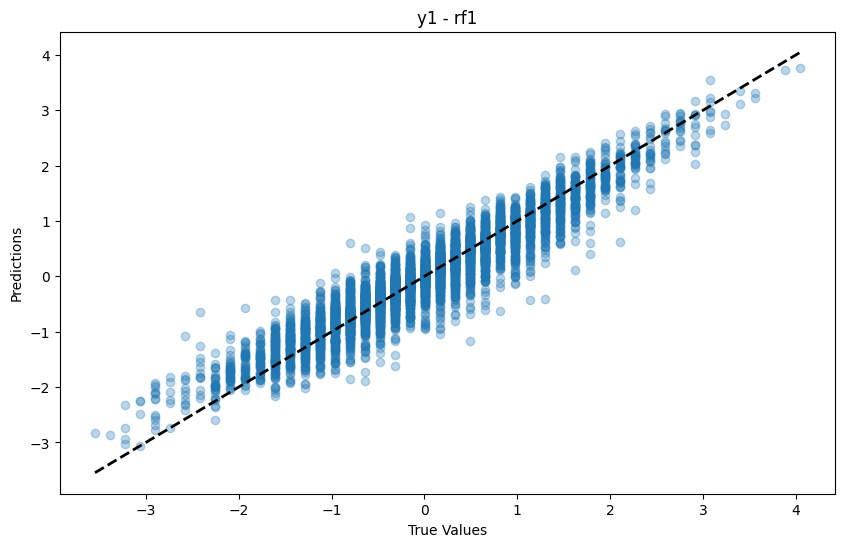

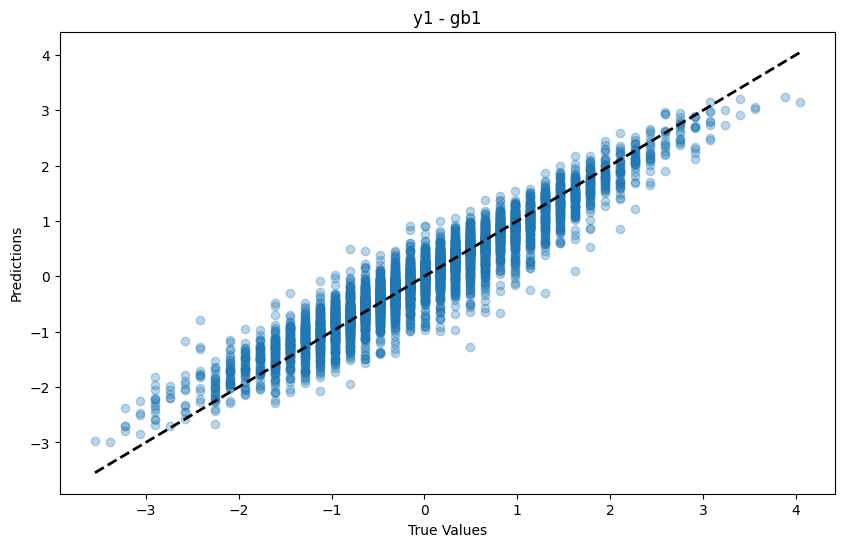

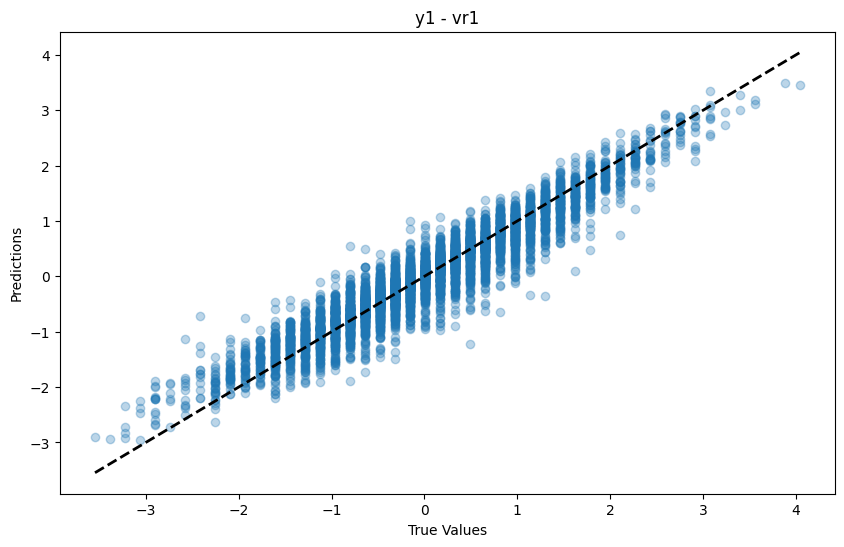

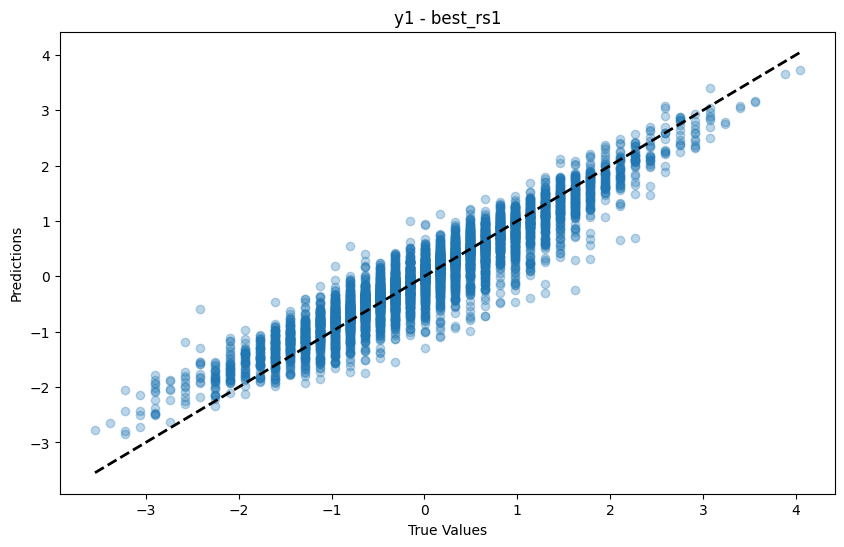

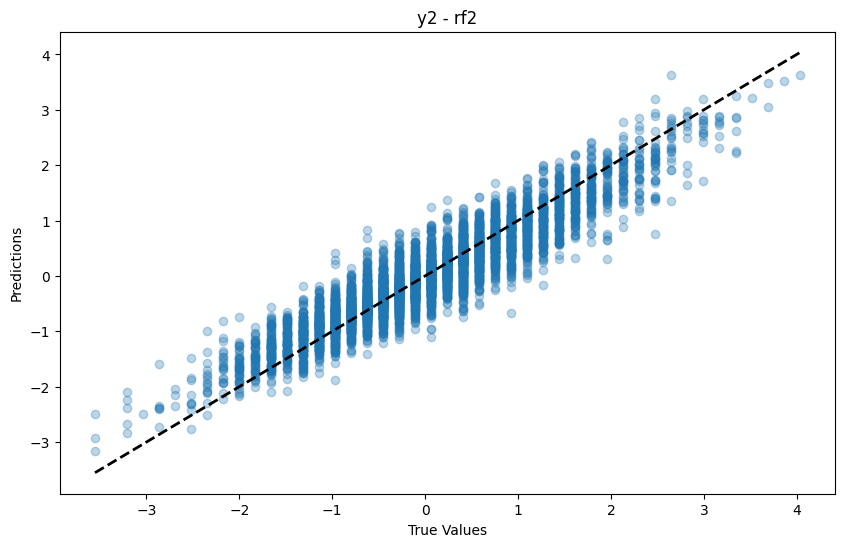

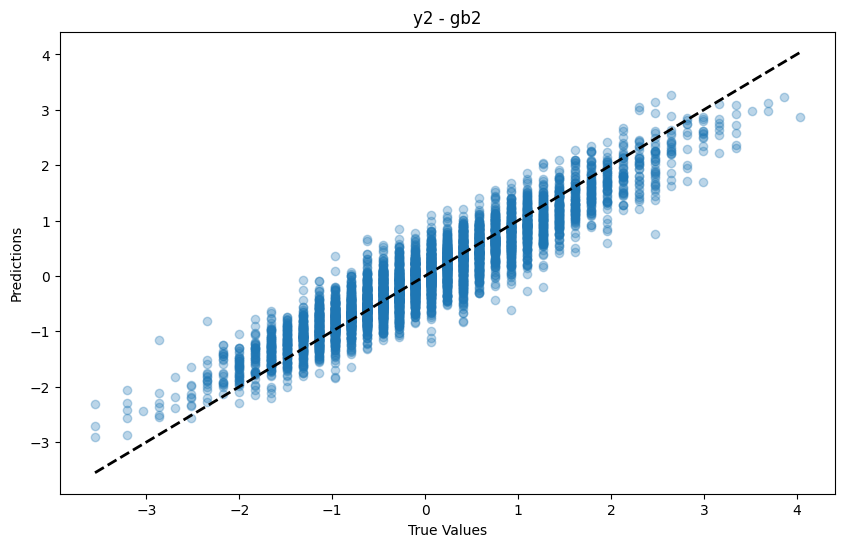

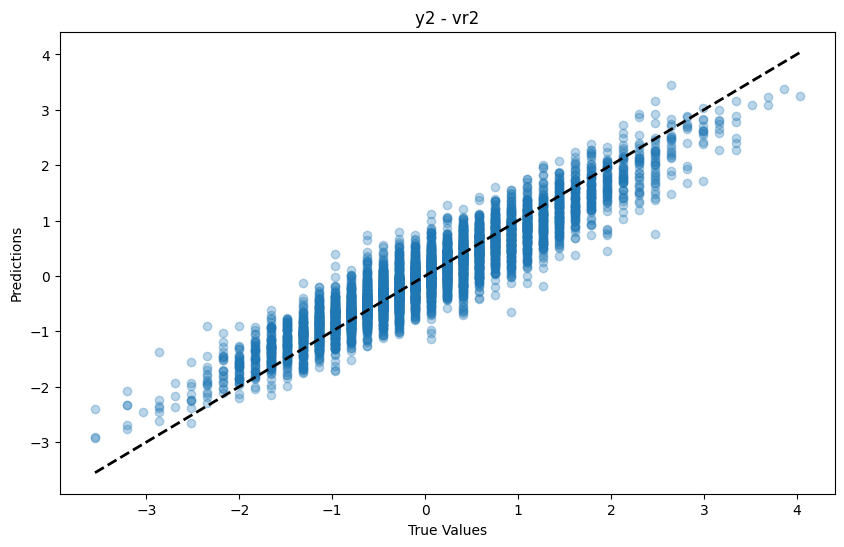

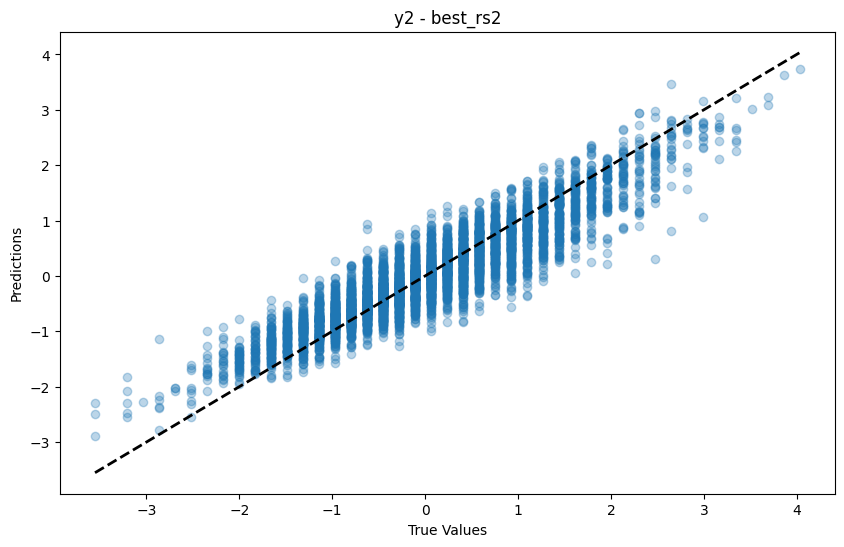

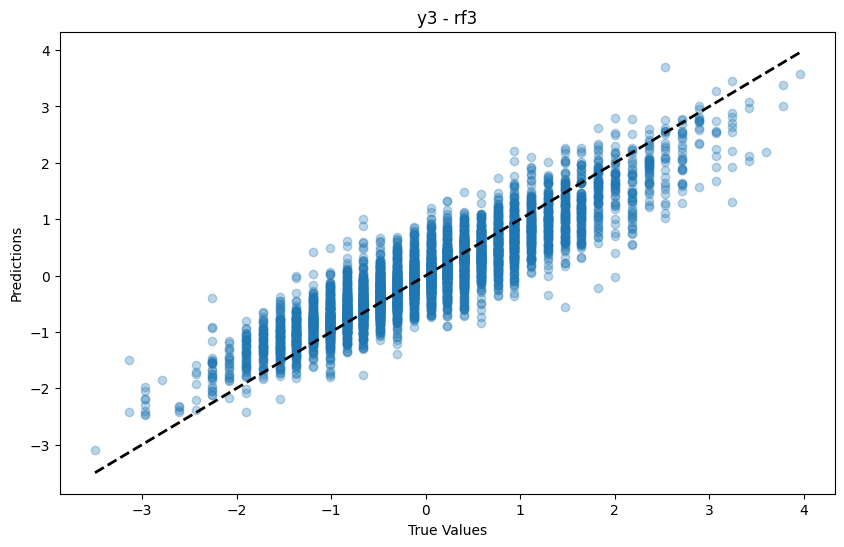

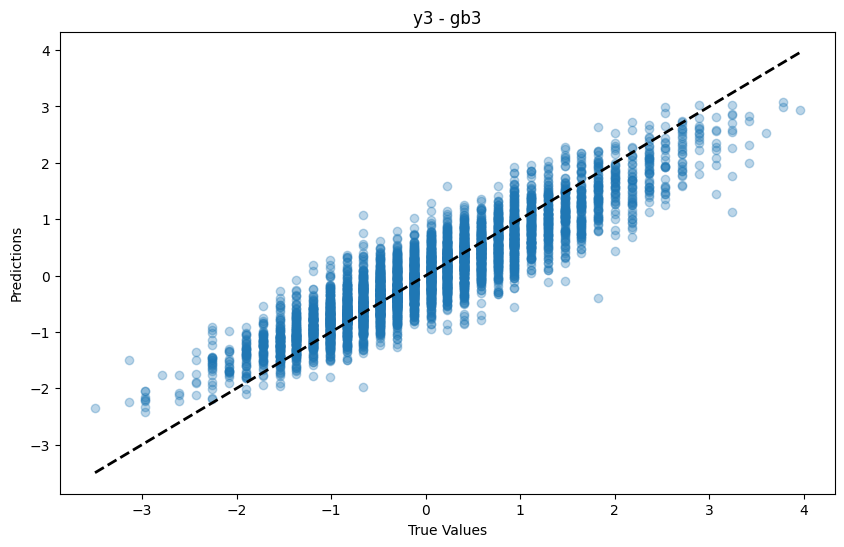

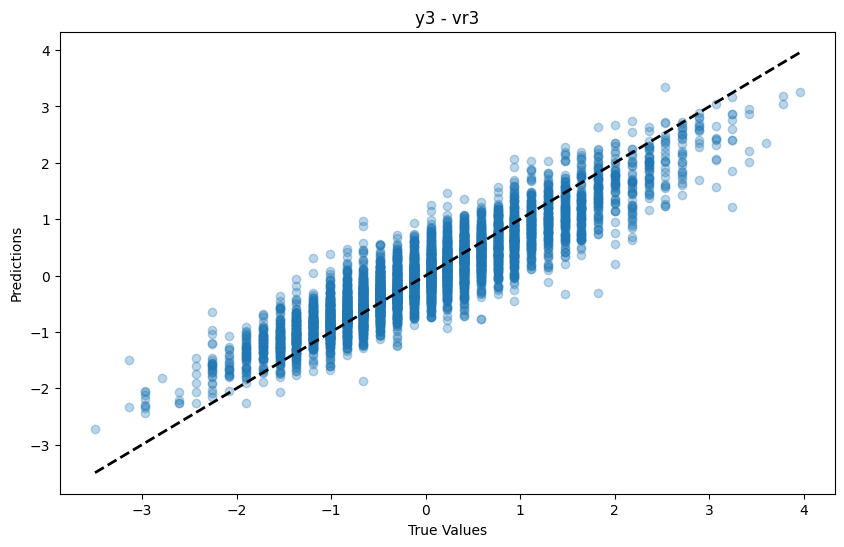

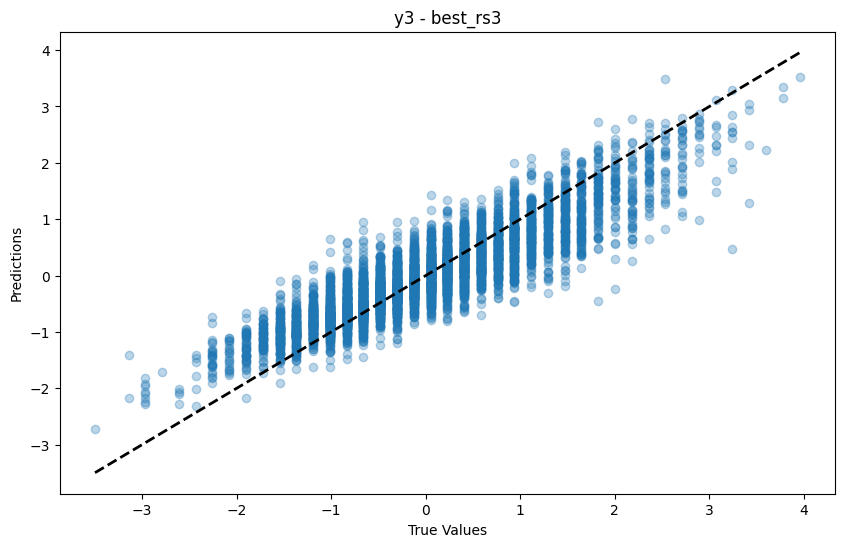

                 RMSE       R^2
y1 rf1       0.324761  0.894738
   gb1       0.313148  0.902131
   vr1       0.314708  0.901153
   best_rs1  0.337865  0.886071
y2 rf2       0.372375  0.860832
   gb2       0.359492  0.870295
   vr2       0.358150  0.871262
   best_rs2  0.403687  0.836443
y3 rf3       0.428664  0.816064
   gb3       0.419146  0.824141
   vr3       0.414145  0.828313
   best_rs3  0.462813  0.785591


In [56]:
import pandas as pd
import joblib
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Caricamento del dataset preprocessato
df = pd.read_csv("new_file.csv")

# Divisione del dataset in set di addestramento, validazione e test
X = df.drop(['overall_next_year', 'overall_next_2year', 'overall_next_3year'], axis=1)
y1 = df['overall_next_year']
y2 = df['overall_next_2year']
y3 = df['overall_next_3year']

X_train, X_temp, y1_train, y1_temp = train_test_split(X, y1, test_size=0.2, random_state=42)
_, _, y2_train, y2_temp = train_test_split(X, y2, test_size=0.2, random_state=42)
_, _, y3_train, y3_temp = train_test_split(X, y3, test_size=0.2, random_state=42)

X_val, X_test, y1_val, y1_test = train_test_split(X_temp, y1_temp, test_size=0.5, random_state=42)
_, _, y2_val, y2_test = train_test_split(X_temp, y2_temp, test_size=0.5, random_state=42)
_, _, y3_val, y3_test = train_test_split(X_temp, y3_temp, test_size=0.5, random_state=42)

# Caricamento dei modelli addestrati
models = {
    'rf1': joblib.load('rf1_model.pkl'),
    'rf2': joblib.load('rf2_model.pkl'),
    'rf3': joblib.load('rf3_model.pkl'),
    'gb1': joblib.load('gb1_model.pkl'),
    'gb2': joblib.load('gb2_model.pkl'),
    'gb3': joblib.load('gb3_model.pkl'),
    'vr1': joblib.load('vr1_model.pkl'),
    'vr2': joblib.load('vr2_model.pkl'),
    'vr3': joblib.load('vr3_model.pkl'),
    'best_rs1': joblib.load('best_rs1_model.pkl'),
    'best_rs2': joblib.load('best_rs2_model.pkl'),
    'best_rs3': joblib.load('best_rs3_model.pkl')
}

# Definizione dei target e i test set per ciascun anno
y_tests = {'y1': y1_test, 'y2': y2_test, 'y3': y3_test}
X_tests = {'y1': X_test, 'y2': X_test, 'y3': X_test}

# Associazione dei modelli agli anni
model_mapping = {
    'y1': ['rf1', 'gb1', 'vr1', 'best_rs1'],
    'y2': ['rf2', 'gb2', 'vr2', 'best_rs2'],
    'y3': ['rf3', 'gb3', 'vr3', 'best_rs3']
}

# Calcolo delle metriche e visualizzazione dei risultati
results = {}

for target in ['y1', 'y2', 'y3']:
    results[target] = {}
    for model_name in model_mapping[target]:
        model = models[model_name]
        y_pred = model.predict(X_tests[target])
        rmse = np.sqrt(mean_squared_error(y_tests[target], y_pred))
        r2 = r2_score(y_tests[target], y_pred)
        results[target][model_name] = {'RMSE': rmse, 'R^2': r2}

        # Plot dei risultati
        plt.figure(figsize=(10, 6))
        plt.scatter(y_tests[target], y_pred, alpha=0.3)
        plt.plot([y_tests[target].min(), y_tests[target].max()], [y_tests[target].min(), y_tests[target].max()], 'k--', lw=2)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        plt.title(f'{target} - {model_name}')
        plt.show()

# Visualizzazione dei risultati in una tabella
results_df = pd.DataFrame.from_dict({(i,j): results[i][j] 
                           for i in results.keys() 
                           for j in results[i].keys()},
                       orient='index')

print(results_df)


# Stampa risultati ottenuti

In [64]:
import pandas as pd
from sklearn.ensemble import VotingRegressor
import joblib

# Caricamento del dataset preprocessato
df = pd.read_csv("new_file.csv")

# Divisione del dataset in set di addestramento e test
X = df.drop(['overall_next_year', 'overall_next_2year', 'overall_next_3year'], axis=1)
y1 = df['overall_next_year']
y2 = df['overall_next_2year']
y3 = df['overall_next_3year']

# Caricamento dei modelli addestrati
vr1 = joblib.load('vr1_model.pkl')
vr2 = joblib.load('vr2_model.pkl')
vr3 = joblib.load('vr3_model.pkl')

# Previsione degli overall per i prossimi tre anni
df['predicted_overall_next_year'] = vr1.predict(X)
df['predicted_overall_next_2year'] = vr2.predict(X)
df['predicted_overall_next_3year'] = vr3.predict(X)

# Salvataggio del dataset aggiornato con le previsioni in un file CSV
df.to_csv('updated_dataset_with_predictions.csv', index=False)

print("CSV con previsioni salvato come 'updated_dataset_with_predictions.csv'")


CSV con previsioni salvato come 'updated_dataset_with_predictions.csv'
